# Aimsun SQLite Output Database Analyzer

### Goal of the notebook

This purpose of this Jupyter notebook is to process the database produced by the Aimsun simulations.
***
**Outputs:** 

Comparsion plots:
- compare_link_flow.png
- compare_speed.png
- compare_travel_time.png
- compare_path_flow.png


**Inputs:** 

Aimsun simulation outputs:
- aimsun-outputs.sqlite
- aimsun_outputs.csv

Ground truth data:
- ground.sqlite
- ground.csv


**Dependent scripts:** 
None

 **IMPORTANT:** Run the iPython cell below in order to import the necessary packages.

In [2]:
# Root path of Fremont Dropbox
import os
import sys
# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from fremontdropbox import get_dropbox_location

path_dropbox = get_dropbox_location()
data_folder = os.path.join(path_dropbox, 'Private Structured data collection')
sql_folder = os.path.join(data_folder, 'Aimsun','Outputs')

In [56]:
import numpy as np
import scipy
import matplotlib
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

### SQLite Helper Functions

These functions are wrapper functions for the underlying SQLite commands we use to query data from the SQLite database. The notebook assumes that the Aimsun database file has been placed into the current directory of the notebook.

In [4]:
def create_connection(db_file):
    conn = sqlite3.connect(db_file)
 
    return conn

def select_all_from_table(conn, table, should_print = True):
    cur = conn.cursor()
    
    if should_print:
        # Prevents us from accidentally clogging up the notebook with huge print statements
        cur.execute("SELECT * FROM {} LIMIT 10".format(table))
    else:
        cur.execute("SELECT * FROM {}".format(table))

    rows = cur.fetchall()

    if should_print:
        for row in rows:
            print(row)
    
    return rows

def select_where_from_table(conn, table, clause, should_print = True):
    cur = conn.cursor()
    cur.execute("SELECT * FROM {} WHERE {}".format(table, clauses))
 
    rows = cur.fetchall()
 
    if should_print:
        for row in rows:
            print(row)
    
    return rows

def show_all_tables(conn, should_print = True):
    cur = conn.cursor()
    cur.execute('SELECT name from sqlite_master where type= "table"')
 
    rows = cur.fetchall()
 
    if should_print:
        for row in rows:
            print(row)
    
    return rows

### SimulatorInfo Class (SIM_INFO Table)

This class parses information from the ```SIM_INFO``` table in the Aimsun database. This table stores meta information about the simulation in general, including the owner of the file and the version number currently in use.

In [5]:
class SimulatorInfo:
    
    def __init__(self, values):
        self.data_id = values[0]
        self.data_id_name = values[1]
        self.effective_data_id = values[2]
        
        self.uses_external_id = True if values[3] else False
        
        self.scenario_date = values[4]
        self.start_time = values[5]
        self.duration = values[6]
        
        self.rand_seed = values[7]
        
        self.type = 'Simulated Data' if values[8] == 1 else 'Average'
        self.warm_up_time = values[9]
        
        self.sim_model = values[11]
        self.aimsun_version = values[12]
        self.num_iters = values[13]
        self.exec_date = values[14]
        
        self.experiment_id = values[14]
        self.experiment_name = values[15]
        
        self.scenario_id = values[17]
        self.scenario_name = values[18]
        
        self.author = values[28]

    def __str__(self):
        delimiter = ","
        
        return "Data ID: {}{}".format(self.data_id, delimiter) +\
            "Data ID Name: {}{}".format(self.data_id_name, delimiter) +\
            "Start Time: {}{}".format(self.start_time, delimiter) +\
            "Duration: {}{}".format(self.duration, delimiter) +\
            "Type: {}{}".format(self.type, delimiter) +\
            "Simulation Model: {}{}".format(self.sim_model, delimiter) +\
            "Execution Date: {}{}".format(self.exec_date, delimiter) +\
            "Scenarion Name: {}{}".format(self.scenario_name, delimiter) +\
            "Owner: {}".format(self.author)
    
    def __repr__(self):
        return str(self)

### Lane Class (MILANE Table)

This class parses information from the ```MILANE``` table in the Aimsun database. This table stores microsimulator result statistical information about each lane of the sections for each period.

In [6]:
class Lane:
    
    def __init__(self, values):
        self.replication_id = values[0]
        self.section_id = values[1]
        self.external_id = values[2]
        self.vehicle_type = values[3]
        self.time_interval = values[4]
        self.lane_id = values[5]
        self.vehicle_cnt = values[6]
        self.flow = values[7]
        self.input_vehicle_cnt = values[8]
        self.input_flow = values[9]
        self.density = values[10]
        self.queue_length = values[11]
        self.queue_max_length = values[12]
        self.delay_time = values[13]
        self.queue_waiting_time = values[14]
        self.speed = values[15]
        self.harmonic_speed = values[16]
        self.travel_time = values[17]
        self.stop_time = values[18]
    
    def __str__(self):
        delimiter = ","
        
        return "External ID: {}{}".format(self.external_id, delimiter) +\
            "Time Interval: {}{}".format(self.time_interval, delimiter) +\
            "Vehicle Count: {}{}".format(self.vehicle_cnt, delimiter) +\
            "Avg. Flow: {}{}".format(self.flow, delimiter) +\
            "Avg. Density: {}{}".format(self.density, delimiter) +\
            "Avg. Queue Length: {}{}".format(self.queue_length, delimiter) +\
            "Avg. Delay Time: {}{}".format(self.delay_time, delimiter) +\
            "Avg. Travel Time: {}".format(self.travel_time)
    
    def __repr__(self):
        return str(self)

### Node Class (MINODE Table)

This class parses information from the ```MINODE``` table in the Aimsun database. This table stores microsimulator result statistical information about each node for each period.

In [7]:
class Node:
    
    def __init__(self, values):
        self.replication_id = values[0]
        self.section_id = values[1]
        self.external_id = values[2]
        self.vehicle_type = values[3]
        self.time_interval = values[4]
        self.approach_delay = values[5]
        self.lost_vehicles = values[6]
        self.missed_turnings = values[7]
    
    def __str__(self):
        delimiter = ","
        
        return "External ID: {}{}".format(self.external_id, delimiter) +\
            "Time Interval: {}{}".format(self.time_interval, delimiter) +\
            "Avg. Approach Delay: {}{}".format(self.approach_delay, delimiter) +\
            "Lost Vehicles: {}{}".format(self.lost_vehicles, delimiter) +\
            "Missed Turnings: {}".format(self.missed_turnings)
    
    def __repr__(self):
        return str(self)

### Detector Class (MIDETEC Table)

This class parses information from the ```MIDETEC``` table in the Aimsun database. This table stores microsimulator result statistical information collected by a detector in a road section.

In [8]:
class Detector:
    
    def __init__(self, values):
        self.replication_id = values[0]
        self.section_id = values[1]
        self.external_id = values[2]
        self.vehicle_type = values[3]
        self.time_interval = values[4]
        self.vehicle_count = values[5]
        self.flow = values[6]
        self.speed = values[7]
        self.occupancy = values[8]
        self.density = values[9]
        self.headway = values[10]
    
    def __str__(self):
        delimiter = ","
        
        return "External ID: {}{}".format(self.external_id, delimiter) +\
            "Time Interval: {}{}".format(self.time_interval, delimiter) +\
            "Vehicle Count: {}{}".format(self.vehicle_count, delimiter) +\
            "Flow: {}{}".format(self.flow, delimeter) +\
            "Avg. Speed: {}{}".format(self.speed, delimiter) +\
            "Avg. Occupancy: {}{}".format(self.occupancy, delimiter) +\
            "Avg. Density: {}{}".format(self.density, delimiter) +\
            "Avg. Headway: {}".format(self.headway)
    
    def __repr__(self):
        return str(self)

### Main AimsunAnalyzer Class

To be implemented. The skeleton code has been given below.

In [9]:
class AimsunAnalyzer:
    
    def __init__(self, simulation_file, simulation_filetype, ground_truth_file = None, ground_truth_filetype = None):
        """
        Initializes the Aimsun analyzer.
        
        @param simulation_file:          The file path of the source file of Aimsun macro/microsimulation outputs.
        @param simulation_filetype:      The type of the src_simulation file (can be .csv or .sqlite).
        @param ground_truth_file:        The file path of the source file of Aimsun macro/microsimulation outputs.
        @param ground_truth_filetype:    The type of the src_simulation file (can be .csv or .sqlite).
        """
        self.database = simulation_file
        self.conn = create_connection(self.database)
        print("=====Connection Established.=====")
        
        self.model_info = SimulatorInfo(select_all_from_table(self.conn, "SIM_INFO", should_print = True)[0])
        print("=====Model Information Loaded.=====")
        
        self.nodes = {}
        self.lanes = {}
        self.detectors = {}

        for row in select_all_from_table(self.conn, "MINODE", should_print = False):
            node = Node(row)
            self.nodes[node.external_id] = node

        for row in select_all_from_table(self.conn, "MILANE", should_print = False):
            lane = Lane(row)
            self.lanes[lane.external_id] = lane

        for row in select_all_from_table(self.conn, "MIDETEC", should_print = False):
            detector = Detector(row)
            self.detectors[detector.external_id] = detector
            
        print("=====Simulation Data Loaded.=====")
        
        self.ground_truth_file = ground_truth_file
        self.ground_truth_filetype = ground_truth_filetype
    
    def get_link_flow(self, road_id, time_interval):
        """
        Returns the link flow for a road_id at a certain time interval.

        @param road_id:         The external ID of the road in Aimsun.
        @param time_interval:   The starting time interval.

        @return:                The link flow on the road with road_id within the time interval.
        """
        return self.lanes[road_id].flow

    def get_speed(self, road_id, time_interval):
        """
        Returns the speed for a road_id at a certain time interval.

        @param road_id:         The external ID of the road in Aimsun.
        @param time_interval:   The starting time interval.

        @return:                The link flow on the road with road_id within the time interval.
        """
        return self.lanes[road_id].speed

    def get_travel_time(self, o_id, d_id, time_interval):
        """
        Returns the time interval to get from an origin ID to a destination ID, starting at a certain time interval.

        @param o_id:            The external ID of the origin centroid.
        @param d_id:            The external ID of the destination centroid.
        @param time_interval:   The starting time interval.

        @return:                The travel time within the time interval from o_id to d_id
        """
        pass

    def get_path_flow(self, o_id, d_id, time_interval):
        """
        Returns the path flow from an origin ID to a destination ID, starting at a certain time interval.

        @param o_id:            The external ID of the origin centroid.
        @param d_id:            The external ID of the destination centroid.
        @param time_interval:   The starting time interval.

        @return:                The path flow within the time interval between start_time and end_time and
                                from o_id to d_id formatted as [(road_ids_1, flow_1), (road_ids_2, flow_2), ...]
        """
        pass

    def compare_flows(self, road_ids, time_interval, src_simulation, src_type_simuatlion):
        """
        Returns a matplotlib plot with comparison information on the flows for the given road IDs at the
        specified time intervals.

        @param road_ids:              A list of the road IDs to be compared.
        @param time_interval:         A list of the corresponding time intervals for the road IDs.

        @return:                      A comparison plot in Matplotlib for the link flows.
        @return:                      The list of link flows within the time interval between start_time
                                      and end_time on roads with road_ids.
        """
        if self.ground_truth_data is None:
            print("Error: No ground truth has been passed in.")

    def compare_speed(self, road_ids, time_intervals, src_simulation, src_type_simulation):
        """
        Returns a matplotlib plot with comparison information on the avg. speeds for the given road IDs at the
        specified time intervals.

        @param road_ids:              A list of the road IDs to be compared.
        @param time_intervals:        A list of the corresponding time intervals for the road IDs.

        @return:                      A comparison plot in Matplotlib for the average speeds.
        @return:                      The list of speed within the time interval between start_time and
                                      end_time on roads with road_ids.
        """
        if self.ground_truth_data is None:
            print("Error: No ground truth has been passed in.")

    def compare_travel_time(self, od_ids, time_intervals):
        """
        Returns a matplotlib plot with comparison information on the travel times for the given origin/destination
        centroid IDs at the specified time intervals.

        @param od_ids:                A list of tuples of (o_id, d_id)
        @param time_interval:         A list of the corresponding time intervals for the road IDs.

        @return:                      A comparison plot in Matplotlib for the average travel times.
        @return:                      The list of travel time within the time interval between start_time
                                      and end_time and from o_ids to d_ids.
        """
        if self.ground_truth_data is None:
            print("Error: No ground truth has been passed in.")

    def compare_path_flow(self, od_ids, time_intervals):
        """
        Returns a matplotlib plot with comparison information on the path flows for the given origin/destination
        centroid IDs at the specified time intervals.

        @param od_ids:                A list of tuples of (o_id, d_id)
        @param time_interval:         A list of the corresponding time intervals for the road IDs.

        @return:                      A comparison plot in Matplotlib for the average path flows.
        @return:                      The list path flow within the time interval between start_time
                                      and end_time and from o_ids to d_ids.
        """
        if self.ground_truth_data is None:
            print("Error: No ground truth has been passed in.")

## Main Code

This section contains the code that should be run in order to generate results in this notebook. Below is the necessary starter code that connects to the database and outputs the current simulator info:

In [10]:
database = os.path.join(sql_folder, "2017.sqlite")
analyzer = AimsunAnalyzer(database, "sqlite")

=====Connection Established.=====
(27989, 'Replication 27989', 27989, None, 0, '1970-01-02', 50400, 21600, 2343, 1, 0, 'micro', '8.4.0 (Thu May 16 2019 afba3b3059)', 1, '2020-03-07T00:23:55', 27988, 'Micro SRC Experiment 27988', 27981, 'Dynamic Scenario 27981', 36, 36, 36, 36, '{2a1b3ea2-88fa-4046-8bbb-05aae50a68bc}', 27979, 0, 62192, '2020-03-07T04:09:19', 'Theo', None)
=====Model Information Loaded.=====
=====Simulation Data Loaded.=====


The code below shows usage of the analyzer API.

In [36]:
print("Link Flow for Lane w/ external ID 252: ", analyzer.get_link_flow("252", 1))
print("Speed for Lane w/ external ID 252: ", analyzer.get_speed("252", 1))

Link Flow for Lane w/ external ID 252:  -1.0
Speed for Lane w/ external ID 252:  -1.0


In [39]:
analyzer.lanes

{'1': External ID: 1,Time Interval: 0,Vehicle Count: 3.0,Avg. Flow: -1.0,Avg. Density: 3.0,Avg. Queue Length: -1.0,Avg. Delay Time: -1.0,Avg. Travel Time: -1.0,
 '2': External ID: 2,Time Interval: 0,Vehicle Count: 12.0,Avg. Flow: -1.0,Avg. Density: 13.0,Avg. Queue Length: -1.0,Avg. Delay Time: -1.0,Avg. Travel Time: -1.0,
 '3': External ID: 3,Time Interval: 0,Vehicle Count: 13.0,Avg. Flow: -1.0,Avg. Density: 13.0,Avg. Queue Length: -1.0,Avg. Delay Time: -1.0,Avg. Travel Time: -1.0,
 '4': External ID: 4,Time Interval: 0,Vehicle Count: 0.0,Avg. Flow: -1.0,Avg. Density: 0.0,Avg. Queue Length: -1.0,Avg. Delay Time: -1.0,Avg. Travel Time: -1.0,
 '5': External ID: 5,Time Interval: 0,Vehicle Count: 0.0,Avg. Flow: -1.0,Avg. Density: 0.0,Avg. Queue Length: -1.0,Avg. Delay Time: -1.0,Avg. Travel Time: -1.0,
 '6': External ID: 6,Time Interval: 0,Vehicle Count: 0.0,Avg. Flow: -1.0,Avg. Density: 0.0,Avg. Queue Length: -1.0,Avg. Delay Time: -1.0,Avg. Travel Time: -1.0,
 '7': External ID: 7,Time Inte

### Skeleton codes begin here, will be written as functions later

In [18]:
id_corr_folder = os.path.join(data_folder,"Data processing","Temporary exports to be copied to processed data","Network","Infrastructure")
id_city_file_name = "detectors_to_road_segments_2019.csv"
id_pems_file_name = "detectors_to_road_segments_pems.csv"

detector_id_to_road_eid_city = pd.read_csv(os.path.join(id_corr_folder,id_city_file_name)).astype(int)
detector_id_to_road_eid_pems = pd.read_csv(os.path.join(id_corr_folder,id_pems_file_name)).astype(int)

display(detector_id_to_road_eid_city.head(5))

,Detector_Id,eid
0,201901,30044
1,201902,35160
2,201903,8549
3,201904,8548
4,201905,35233


### Compare flow

In [60]:
flow_ground_folder = os.path.join(data_folder,"Data processing","Temporary exports to be copied to processed data","Demand","Flow_speed")
flow_ground_file_name = "flow_processed_2019.csv"
flow_ground = pd.read_csv(os.path.join(flow_ground_folder, flow_ground_file_name)).fillna(0)
flow_ground["Road_Id"] = flow_ground["Road_Id"].astype(int).astype(str)
flow_ground["Detector_Id"] = flow_ground["Detector_Id"].astype(int).astype(str)
display(flow_ground.head(2))

,Name,Detector_Id,Road_Id,Year,0:0,0:15,0:30,0:45,1:0,1:15,...,21:30,21:45,22:0,22:15,22:30,22:45,23:0,23:15,23:30,23:45
0,AUTO MALL PKWY BT FREMONT BLVD AND I-680 EB.csv,201901,30044,2019,51.666667,50.666667,44.0,45.666667,31.666667,29.666667,...,223.333333,160.333333,141.333333,103.666667,108.000000,70.666667,68.333333,92.000000,84.333333,60.666667
1,AUTO MALL PKWY BT FREMONT BLVD AND I-680 WB.csv,201902,35160,2019,30.000000,21.000000,21.0,24.333333,22.666667,20.666667,...,132.000000,120.333333,92.333333,91.333333,70.666667,55.333333,41.000000,48.333333,35.333333,39.333333


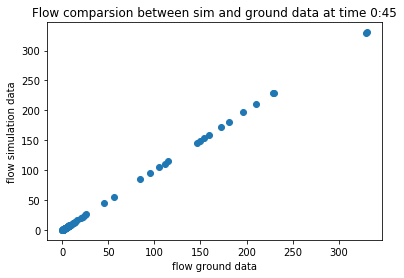

In [65]:
# compare ground data with simulation data
# for example, we want to get the flow comparison at 0:45 
# Potential problem: the simulation data is not informative, don't know how to specify time interval when retriving sim flow data
time_interval = ["0:45"]
for time in time_interval:
    flow_ground["sim_flow_"+str(time)]=flow_ground.apply(lambda row : analyzer.get_link_flow(row['Road_Id'], time), axis=1)

# plot biplot for each time period
for time in time_interval:
    fig = plt.figure()
    plt.scatter(flow_ground[time], flow_ground[time]) # TO BE CHANGED
    #plt.scatter(flow_ground[time], flow_ground["sim_flow_"+str(time)])
    plt.xlabel("flow ground data")
    plt.ylabel("flow simulation data")
    plt.title("Flow comparsion between sim and ground data at time "+time)

# display(flow_ground)

### Comparing speed

In [63]:
# wait for updated detector_id and road_id, currently all set to 0
# better to have average speed data in the csv, which is really easy to get from the raw data
speed_ground_folder = os.path.join(data_folder,"Data processing","Temporary exports to be copied to processed data","Demand","Flow_speed")
speed_ground_file_name = "2015_Speed_Processed_Percent.csv"
speed_ground = pd.read_csv(os.path.join(speed_ground_folder, speed_ground_file_name)).fillna(0)
speed_ground["Road_Id"] = speed_ground["Road_Id"].astype(int).astype(str)
speed_ground["Detector_Id"] = speed_ground["Detector_Id"].astype(int).astype(str)
speed_ground["Mean_speed"] = 0 # better to have in the csv
display(speed_ground.head(4))


,Unnamed: 0,Name,Detector_Id,Road_Id,StartTime,EndTime,Direction,Speed limit,50,49,...,8,7,6,5,4,3,2,1,0,Mean_speed
0,EB_Cum,60 - Grimmer Blvd - Paseo Padre Pkwy to Osgood...,0,0,10:30:00,11:20:00,EB,40 mph,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,0
1,WB_Cum,60 - Grimmer Blvd - Paseo Padre Pkwy to Osgood...,0,0,10:30:00,11:20:00,WB,40 mph,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,0
2,NB_Cum,83 - Mission Blvd - Pine St to Durham Rd.xls,0,0,12:15:00,12:45:00,NB,45 mph,0.0,0.0,...,0.904762,0.942857,0.942857,0.990476,1.0,1.0,1.0,1.0,1.0,0
3,SB_Cum,83 - Mission Blvd - Pine St to Durham Rd.xls,0,0,12:15:00,12:45:00,SB,45 mph,0.0,0.0,...,0.909091,0.927273,0.963636,1.000000,1.0,1.0,1.0,1.0,1.0,0


In [ ]:
# for example, we want to get the speed comparison at 0:45 
# Potential problem: the simulation data is not informative. We don't know how to specify time interval when retriving sim speed data
time_interval = ["0:45"]
for time in time_interval:
    speed_ground["sim_speed_"+str(time)]=speed_ground.apply(lambda row : analyzer.speed(row['Road_Id'], time), axis=1)

# plot biplot for each time period
for time in time_interval:
    fig = plt.figure()
    plt.scatter(speed_ground["Mean_speed"], speed_ground["sim_speed_"+str(time)])
    plt.xlabel("speed ground data")
    plt.ylabel("speed simulation data")
    plt.title("Speed comparsion between sim and ground data at time "+time)
